In [4]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests

import json
import string
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange, MO, TU, WE, TH, FR, SA, SU)

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime,timedelta,date
import seaborn as sns
%matplotlib inline

import fitz
import html
import twitter
import sys

sys.path.append("/Users/mharias/Documents/proyectos/mylibs") # directorio de acceso a librerías auxiliares


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/_p/bc_h4mbs0350g3s_n60vsd3c0000gp/T/ipykernel_22940/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [6]:
FUENTE  = 'http://data.cnmc.es/datagraph/'
AUTOR = '@walyt'

In [32]:
PATH = '/Users/mharias/documents/proyectos/estadisticas_telco/'
PATH_DATOS = 'data/'
PATH_MES = 'mensual_ENERO_2022/'
PATH_MES = 'mensual_FEBRERO_2022/'
PATH_MES = 'mensual_MARZO_2022/'
PATH_MES = 'mensual_ABRIL_2022/'
PATH_IMAGEN = 'img/'
PATH_FIJO ='1. TELEFONIA FIJA/'
PATH_MOVIL = '2. TELEFONIA MOVIL/'
PATH_LINEAS_MOVILES = '2. TELEFONIA MOVIL/'
PATH_BANDA_ANCHA_FIJA_MINORISTA = '4. BANDA ANCHA FIJA MINORISTA/'
PATH_DATOS_3_4_OPERADOR = 'b) Datos por operador/'
PATH_DATOS_2_OPERADOR ='c) Datos por operador/'
PATH_LINEAS ='a) Lineas/'


In [33]:
FILE_4  = '4. Numero de lineas de telefonia movil.xls'
FILE_17 = '17. Lineas de banda ancha fija por operador.xls'
FILE_16 = '16. Lineas de banda ancha fija por tecnologia y por operador.xls'
FILE_M2M = '5. Lineas asociadas a maquinas (M2M).xls'
FILE_FIJO = '1. Numero de lineas de telefonia fija por segmento.xls'
FILE_MOVIL = '9. Portabilidades de numeracion movil.xls'
FILE_LINEAS = '8. Lineas de telefonia movil por operador.xls'
FILE_14 = '14. Lineas de banda ancha fija.xls'



In [34]:
ORDEN_OPERADORES = ['Movistar', 'Orange', 'Vodafone', 'Grupo MASMOVIL', 'Euskaltel','Resto']

COLUMNAS_INTERES = [
       'May-2021', 'Jun-2021', 'Jul-2021', 'Ago-2021', 'Sep-2021',
       'Oct-2021', 'Nov-2021', 'Dic-2021', 'Ene-2022','Feb-2022','Mar-2022','Abr-2022']

PENULTIMO_MES = 'May-2021'
MES_ACTUAL = 'Abr-2022'

# Balance Portabilidades Móviles del mes

In [21]:
portabilidades = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_MOVIL}{PATH_DATOS_2_OPERADOR}{FILE_MOVIL}',skiprows=4,nrows=21)
lineas = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_MOVIL}{PATH_DATOS_2_OPERADOR}{FILE_LINEAS}',skiprows=4,nrows=7)

In [22]:
portabilidades = (
    portabilidades.
    assign(operador = portabilidades['Unnamed: 1'].fillna('Total')).
    assign(sentido = portabilidades['Unnamed: 0'].fillna(method='ffill')).
    drop(['Unnamed: 0','Unnamed: 1'],axis=1).
    loc[:,['sentido','operador',MES_ACTUAL]]
)

In [23]:
lineas = (
    lineas.
    assign(operador = lineas['Unnamed: 0']).
    assign(sentido = 'Acumuladas').
    drop(['Unnamed: 0'],axis=1).
    loc[:,['sentido','operador',MES_ACTUAL]]
)

In [24]:
datos = (
    pd.
    concat([lineas,portabilidades],ignore_index=True).
    pivot(index='operador',columns='sentido',values=MES_ACTUAL).
    reset_index()
)

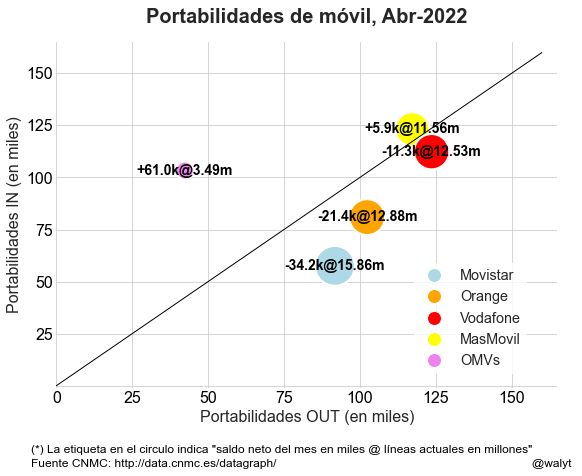

In [25]:
datos_draw = datos.loc[~datos['operador'].isin(['Total','Yoigo']),:]
sns.set_style(style='white')
orden_operadores = ['Movistar','Vodafone','Orange','Grupo MASMOVIL','OMV']
colores  = ['lightblue','red','orange','yellow','violet']
g = sns.relplot(
    data = datos_draw,
    y='Importados',
    x='Exportados',
    hue='operador',
    size='Acumuladas',
    sizes=(320,1590),
    palette=colores,
    legend=False,
    height=8,
    aspect=1,
    hue_order=orden_operadores
).set_axis_labels('Portabilidades OUT (en miles)','Portabilidades IN (en miles)',fontsize=16).despine(left=True,bottom=True)

g.ax.xaxis.set_tick_params(labelsize=16,labelcolor='black',width=0,rotation=0,pad=0)
g.ax.yaxis.set_tick_params(labelsize=16,labelcolor='black',width=0,rotation=0,pad=0)
g.ax.set_xticks([0,25000,50000,75000,100000,125000,150000])
g.ax.set_yticks([0,25000,50000,75000,100000,125000,150000])
g.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.0f}'.format(v/1000)))
g.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f}'.format(v/1000) if v!=0 else ''))
g.ax.set_xlim([0,round(max(datos_draw['Exportados'])+10000,-4)])
g.ax.set_ylim([0,round(max(datos_draw['Importados'])+10000,-4)])
g.ax.set_xlim([-1,165001])
g.ax.set_ylim([-1000,165001])

g.ax.plot(np.linspace(0,160000,100000),np.linspace(0,160000,100000),linewidth=1,color='black')
g.ax.grid(True,axis='both',which='both',fillstyle='full')
g.ax.set_title(label=f'Portabilidades de móvil, {MES_ACTUAL}',fontsize=20,weight='bold',pad=20)
g.fig.subplots_adjust(top=0.8,bottom=.2)
g.ax.text(-.05, -.18, '''(*) La etiqueta en el circulo indica "saldo neto del mes en miles @ líneas actuales en millones"''',horizontalalignment='left',
          verticalalignment='center', fontsize=12,color='black',transform=g.ax.transAxes)
g.ax.text(-.05, -.22, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=12,color='black',transform=g.ax.transAxes)
g.ax.text(.95, -.22, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=12,color='black',transform=g.ax.transAxes)
g.fig.subplots_adjust(top=0.8,bottom=.2)
red_circle = Line2D([0], [0], marker='o', color='r', label='Circle',
                        markerfacecolor='r', markersize=15),
yellow_circle = Line2D([0], [0], marker='o', color='yellow', label='Circle',
                        markerfacecolor='r', markersize=15),
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="lightblue")
line2 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="orange")
line3 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line4 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="yellow")
line5 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="violet")

leyenda = g.ax.legend((line1,line2,line3,line4,line5),
                      ('Movistar','Orange','Vodafone','MasMovil','OMVs'),
                      numpoints=1,
                      loc='center left',
                      bbox_to_anchor=(.7,.2),
                      ncol=1,
                      fontsize='x-large')
leyenda.get_frame().set_linewidth(0.0)
for handle in leyenda.legendHandles:
    handle.set_markersize(14)
#g.ax.legend(labels=['MasMovil','Movistar','MVNOs','Orange','Vodafone'],loc='center left',handles=[red_circle,yellow_circle],bbox_to_anchor=(1,.5),ncol=1,prop={'size':20})
for operador in datos_draw['operador'].unique():
            val_x = datos_draw.loc[datos_draw['operador']==operador,'Exportados'].values[0]
            val_y = datos_draw.loc[datos_draw['operador']==operador,'Importados'].values[0]
            valor_saldo = datos_draw.loc[datos_draw['operador']==operador,'Saldo'].values[0]
            valor_actual = datos_draw.loc[datos_draw["operador"]==operador,"Acumuladas"].values[0]
            valor_texto = f'{valor_saldo/1000:+,.1f}k@{valor_actual/1000000:.2f}m'
            g.ax.text(val_x,val_y,s=valor_texto,ha='center', va='center',fontsize=14,color='black',weight='bold')
g.savefig(f'{PATH}{PATH_IMAGEN}portabilidades_{MES_ACTUAL}.png',bbox_inches='tight')         

# Evolución Portabilidades

In [35]:
portabilidades = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_MOVIL}{PATH_DATOS_2_OPERADOR}{FILE_MOVIL}',skiprows=4,nrows=21)
lineas = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_MOVIL}{PATH_DATOS_2_OPERADOR}{FILE_LINEAS}',skiprows=4,nrows=7)

In [36]:
portabilidades = (
    portabilidades.
    assign(operador = portabilidades['Unnamed: 1'].fillna('Total')).
    assign(sentido = portabilidades['Unnamed: 0'].fillna(method='ffill')).
    drop(['Unnamed: 0','Unnamed: 1'],axis=1).
    loc[:,['sentido','operador']+COLUMNAS_INTERES].
    melt(id_vars=['sentido','operador'],value_vars=COLUMNAS_INTERES)
)

In [37]:
datos_draw=portabilidades.loc[(~portabilidades['operador'].isin(['Yoigo','Total'])) & (portabilidades['sentido']=='Saldo'),:]

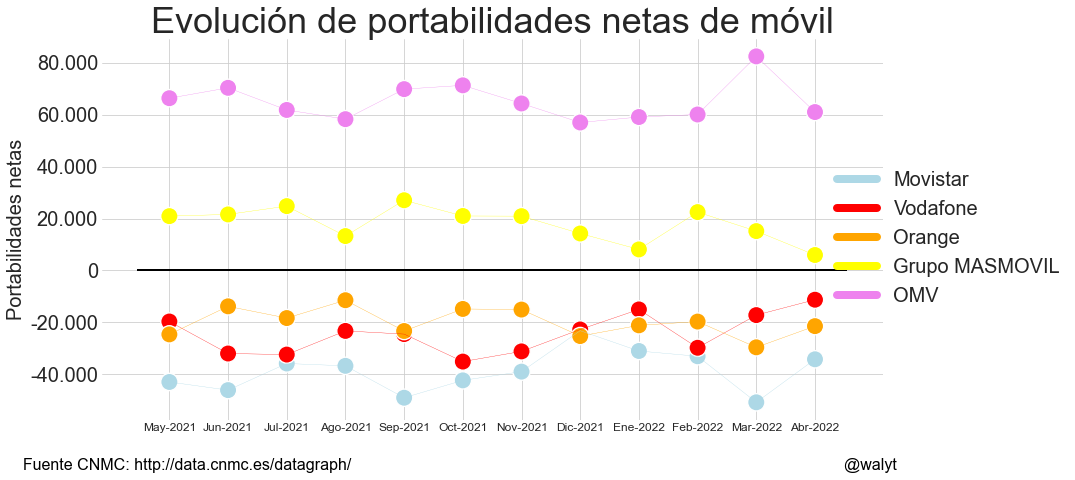

In [38]:
sns.set_style(style='white')

colores = ['lightblue','red','orange','yellow','violet']
orden_operadores = ['Movistar','Vodafone','Orange','Grupo MASMOVIL','OMV']
f, ax = plt.subplots(figsize=(14, 7))

sns.set_style(style='white')
titulo='Evolución de portabilidades netas de móvil'
# calculo medias antes de filtrar las horas

g =sns.scatterplot(data=datos_draw,
                   x='variable',
                   y='value',
                   hue='operador',
                   hue_order=orden_operadores,
                   ax=ax,
                   s=300,
                   palette=colores,
                   alpha=1)

g =sns.lineplot(data=datos_draw,
                x='variable',
                y='value',
                hue='operador',
                ax=ax,
                lw=.3,
                palette=colores)



ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f}'.format(v).replace(',','.')))

ax.hlines(y=0, xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1], linewidth=2, color='black')
ax.set_title(titulo,fontsize=36)
ax.grid(True)

ax.text(-.1, -.12, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(.95, -.12, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Portabilidades netas',fontsize=20)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
handles, labels = ax.get_legend_handles_labels()
leyenda = ax.legend(labels=labels,handles=handles[-5:], loc='upper right',
           fontsize=20,markerscale=5,bbox_to_anchor=(1.25,.7),frameon=False)

for line in leyenda.get_lines():
    line.set_linewidth(8)
    

f.savefig(f'{PATH}{PATH_IMAGEN}historico_portabilidades_{MES_ACTUAL}.png',bbox_inches='tight') 

# Evolución Líneas de Fijo

In [39]:
FILE_FIJO = '1. Numero de lineas de telefonia fija por segmento.xls'

In [40]:
fijo = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_FIJO}{PATH_LINEAS}{FILE_FIJO}',skiprows=4,nrows=3)



In [41]:
columnas_interes = ['Mar-2021',
       'Abr-2021', 'May-2021', 'Jun-2021', 'Jul-2021', 'Ago-2021', 'Sep-2021',
       'Oct-2021', 'Nov-2021', 'Dic-2021', 'Ene-2022','Feb-2022','Mar-2021']

In [42]:
fijo = (
    fijo.
    assign(tipo = fijo['Unnamed: 0']).
    drop(['Unnamed: 0'],axis=1).
    melt(id_vars=['tipo'],value_vars=COLUMNAS_INTERES)
)

In [43]:
fijo['pct'] = fijo.groupby('variable')['value'].transform(lambda x:2*x/x.sum())
fijo['inc'] = fijo.loc[:,['tipo','variable','value']].groupby(['tipo'])['value'].pct_change()

In [44]:
fijo = fijo.loc[fijo['variable'].isin(columnas_interes[1:]),:]

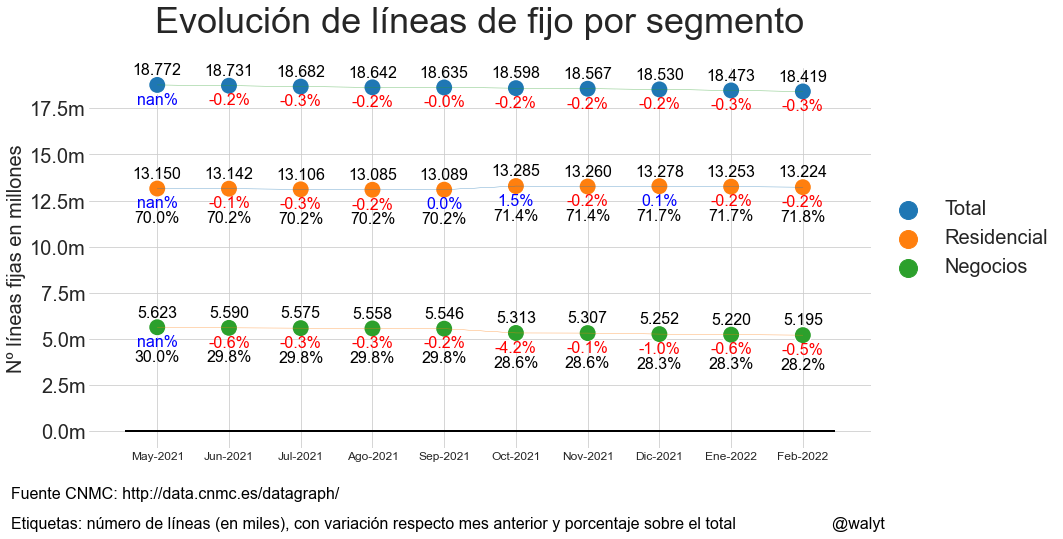

In [45]:
colores = sns.color_palette('tab10')[:3]
orden_tipo = ['Total','Residencial','Negocios']
f, ax = plt.subplots(figsize=(14, 7))

sns.set_style(style='white')
titulo='Evolución de líneas de fijo por segmento'
# calculo medias antes de filtrar las horas

g =sns.scatterplot(data=fijo,
                   x='variable',
                   y='value',
                   hue='tipo',
                   hue_order=orden_tipo,
                   ax=ax,
                   s=300,
                   palette=colores,
                   alpha=1)

g =sns.lineplot(data=fijo,
                x='variable',
                y='value',
                hue='tipo',
                ax=ax,
                lw=.3,
                palette=colores)



for i in fijo.index:
    height = 1
    valor_abs = f'{fijo.loc[i,:].value/1000000:,.3f}'.replace(',','.')
    valor_pct = f'{fijo.loc[i,:].pct:,.1%}'.replace(',','.')
    valor_inc = f'{fijo.loc[i,:].inc:,.1%}'.replace(',','.')
    valor_abs = f'{fijo.loc[i,:].value/1000000:,.3f}'.replace(',','.')
    color_inc = 'red' if fijo.loc[i,:].inc<0 else 'blue'

    if fijo.loc[i,:].tipo!='Total':
        
        ax.text(fijo.loc[i,:].variable,fijo.loc[i,:].value+800000,s=valor_abs,ha='center', va='center',fontsize=16,color='black',weight='regular')
        ax.text(fijo.loc[i,:].variable,fijo.loc[i,:].value-1600000,s=valor_pct,ha='center', va='center',fontsize=16,color='black',weight='regular')
        ax.text(fijo.loc[i,:].variable,fijo.loc[i,:].value-800000,s=valor_inc,ha='center', va='center',fontsize=16,color=color_inc,weight='regular')
    else:
        
        ax.text(fijo.loc[i,:].variable,fijo.loc[i,:].value+800000,s=valor_abs,ha='center', va='center',fontsize=16,color='black',weight='regular')
        ax.text(fijo.loc[i,:].variable,fijo.loc[i,:].value-800000,s=valor_inc,ha='center', va='center',fontsize=16,color=color_inc,weight='regular')





ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.1f}m'.format(v/1000000).replace(',','.')))

ax.hlines(y=0, xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1], linewidth=2, color='black')
ax.set_title(titulo,fontsize=36,pad=35)
ax.grid(True)

ax.text(-.1, -.12, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(-.1, -.2, f'Etiquetas: número de líneas (en miles), con variación respecto mes anterior y porcentaje sobre el total',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(.95, -.2, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Nº líneas fijas en millones',fontsize=20)
sns.despine(left=True, bottom=True)
handles, labels = ax.get_legend_handles_labels()
leyenda = ax.legend(labels=labels,handles=handles[:3], loc='upper right',
           fontsize=20,markerscale=3,bbox_to_anchor=(1.25,.7),frameon=False)

f.savefig(f'{PATH}{PATH_IMAGEN}evolucion_fijo_{MES_ACTUAL}.png',bbox_inches='tight') 

# Líneas M2M

In [49]:
m2m

,variable,value,pct
0,Ene-2015,3067034,NaN
1,Feb-2015,3110584,NaN
2,Mar-2015,3204810,NaN
3,Abr-2015,3276120,NaN
4,May-2015,3342755,NaN
...,...,...,...
83,Dic-2021,8864255,0.153249
84,Ene-2022,8976461,0.154532
85,Feb-2022,9094788,0.157787
86,Mar-2022,9202816,0.178853


In [46]:
m2m = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_MOVIL}{PATH_LINEAS}{FILE_M2M}',skiprows=4,nrows=1)

In [47]:
m2m = (
    m2m.
    drop(['Unnamed: 0'],axis=1).
    melt(value_vars=m2m.columns[1:])
)
m2m['pct'] = m2m['value'].pct_change(12)

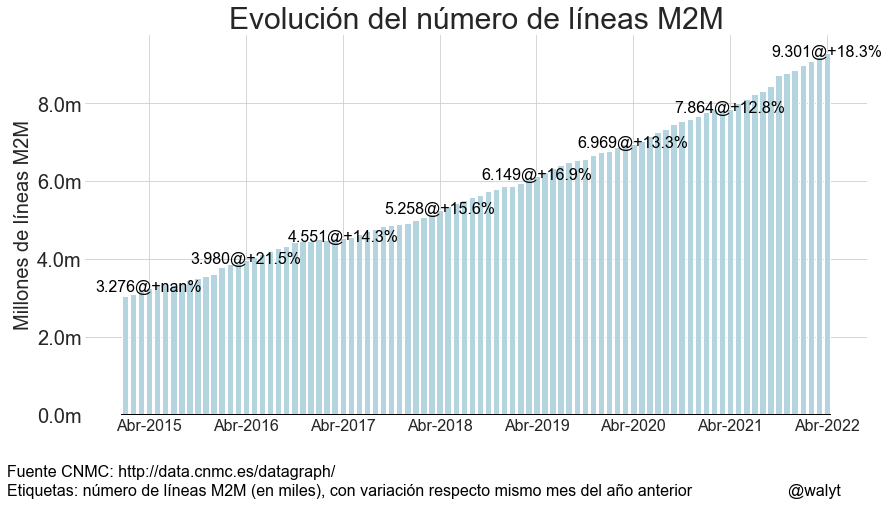

In [53]:
# ojo!!:...hay que cambiar el valor de ax.set_xticks(ax.get_xticks()[3::12]) y de if i%12==3:

COLORES = sns.color_palette('Set2',3)[0]

sns.set_style(style='white')
TITULO='Evolución del número de líneas M2M'
# calculo medias antes de filtrar las horas
f, ax = plt.subplots(figsize=(14, 7))
g =sns.barplot(data=m2m,
                   x='variable',
                   y='value',
               ax=ax,
               color='lightblue'
              )
ax.set_xticks(ax.get_xticks()[3::12])
ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.xaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.1f}m'.format(v/1000000).replace(',','.')))
#ax.set_ylim([-50000,50000])
ax.hlines(y=0, xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1], linewidth=2, color='black')
ax.set_title(TITULO,fontsize=30)
ax.grid(True)

ax.text(-.1, -.15, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(-.1, -.2, f'Etiquetas: número de líneas M2M (en miles), con variación respecto mismo mes del año anterior',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(.9, -.2, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Millones de líneas M2M',fontsize=20)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)

    
patches=ax.patches
for i,rect in enumerate(patches):
    if i%12==3:
        height = rect.get_height()
        valor = f'{height/1000:,.0f}'.replace(',','.') if height>1000000 else f'{height/1000:,.1f}'.replace(',','.')
        pct = m2m.iloc[i,2]
        #pos_y = round(0.05*ax.get_ylim()[1],-4)+(height+suelo[i]) if height>0 else 4000+(height+suelo[i])
        pos_y = height
        texto = f'{valor}@+{pct:,.1%}'
        ax.text(rect.get_x()+rect.get_width()/2,pos_y+25000,s=texto,ha='center', va='center',fontsize=16,color='black',weight='regular')
        

f.savefig(f'{PATH}{PATH_IMAGEN}evolucion_m2m.png',bbox_inches='tight') 

# Evolución de ftths

In [54]:
ftth = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_BANDA_ANCHA_FIJA_MINORISTA}{PATH_DATOS_3_4_OPERADOR}{FILE_17}',skiprows=4,nrows=9)

In [55]:
ftth = (
    ftth.
    assign(operador = ftth['Unnamed: 0']).
    drop(['Unnamed: 0'],axis=1).
    loc[:,['operador']+COLUMNAS_INTERES].
    melt(id_vars=['operador'],value_vars=COLUMNAS_INTERES)
)

In [56]:
datos_draw=ftth.loc[(~ftth['operador'].isin(['Ono','Jazztel','Total'])),:]

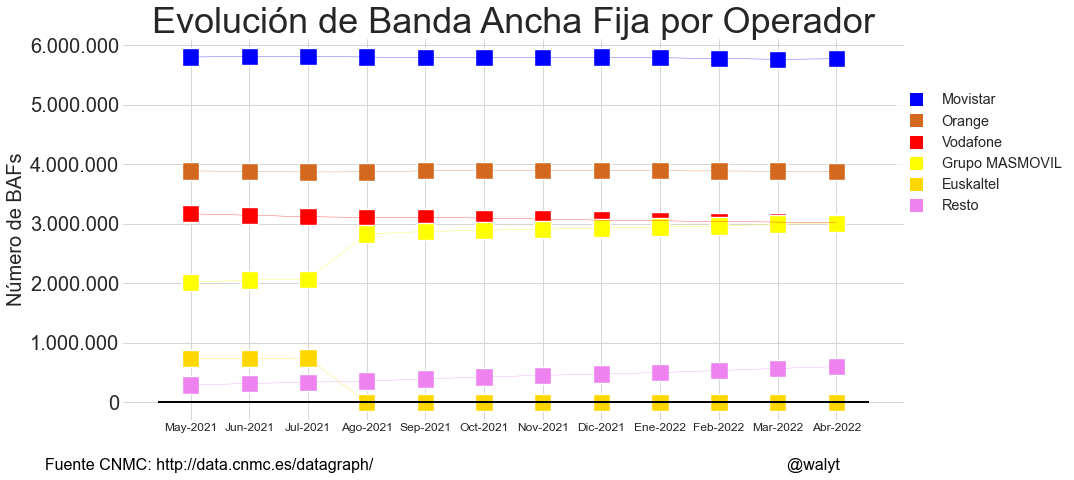

In [57]:
sns.set_style(style='white')

COLORES = sns.color_palette('Set2',10)
COLORES  = ['blue','chocolate','red','yellow','gold','violet']  #https://matplotlib.org/stable/gallery/color/named_colors.html
ORDEN_OPERADORES = ['Movistar', 'Orange', 'Vodafone', 'Grupo MASMOVIL', 'Euskaltel','Resto']
f, ax = plt.subplots(figsize=(14, 7))

sns.set_style(style='white')
TITULO='Evolución de Banda Ancha Fija por Operador'
# calculo medias antes de filtrar las horas

g =sns.scatterplot(data=datos_draw,
                   x='variable',
                   y='value',
                   hue='operador',
                   hue_order=ORDEN_OPERADORES,
                   ax=ax,
                   s=300,
                   marker='s', # https://matplotlib.org/stable/api/markers_api.html
                   palette=COLORES,
                   alpha=1)

g =sns.lineplot(data=datos_draw,
                x='variable',
                y='value',
                hue='operador',
                hue_order=ORDEN_OPERADORES,
                ax=ax,
                lw=.3,
                palette=COLORES
                )



ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f}'.format(v).replace(',','.')))
#ax.set_ylim([-50000,50000])
ax.hlines(y=0, xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1], linewidth=2, color='black')
ax.set_title(TITULO,fontsize=36)
ax.grid(True)

ax.text(-.1, -.12, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(.85, -.12, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.set_xlabel('')
ax.set_ylabel('Número de BAFs',fontsize=20)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
line1 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[0])
line2 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor=COLORES[1])
line3 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[2])
line4 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor=COLORES[3])
line5 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[4])
line6 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[5])

leyenda = ax.legend((line1,line2,line3,line4,line5,line6),
                      ORDEN_OPERADORES,
                      numpoints=1,
                      loc='center left',
                      bbox_to_anchor=(.98,.7),
                      ncol=1,
                      fontsize='x-large')
leyenda.get_frame().set_linewidth(0.0)
for handle in leyenda.legendHandles:
    handle.set_markersize(14)

f.savefig(f'{PATH}{PATH_IMAGEN}historico_bafs_{MES_ACTUAL}.png',bbox_inches='tight') 

In [83]:
ftth.loc[ftth['variable']=='Abr-2022',:]

,operador,variable,value,diferencia
11,Movistar,Abr-2022,5771622,7523.0
23,Orange,Abr-2022,3880410,-3549.0
35,Vodafone,Abr-2022,3020586,-8050.0
47,Grupo MASMOVIL,Abr-2022,3002458,7469.0
59,Euskaltel,Abr-2022,0,0.0
71,Resto,Abr-2022,598324,28883.0


# Evolución de las variaciones de base de FTTHs

In [58]:
ftth = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_BANDA_ANCHA_FIJA_MINORISTA}{PATH_DATOS_3_4_OPERADOR}{FILE_17}',skiprows=4,nrows=9)

In [59]:
ftth = (
    ftth.
    loc[(~ftth['Unnamed: 0'].isin(['Ono','Jazztel','Total'])),:].
    assign(operador = ftth['Unnamed: 0']).
    drop(['Unnamed: 0'],axis=1).
    loc[:,['operador']+COLUMNAS_INTERES].
    melt(id_vars=['operador'],value_vars=COLUMNAS_INTERES).
    set_index(['operador','variable']).
    reindex(ORDEN_OPERADORES,level='operador').
    reindex(COLUMNAS_INTERES,level='variable').
    reset_index()
)


In [60]:
ftth = (ftth.
        assign(diferencia = ftth.groupby(['operador'],sort=False)['value'].diff())
       )

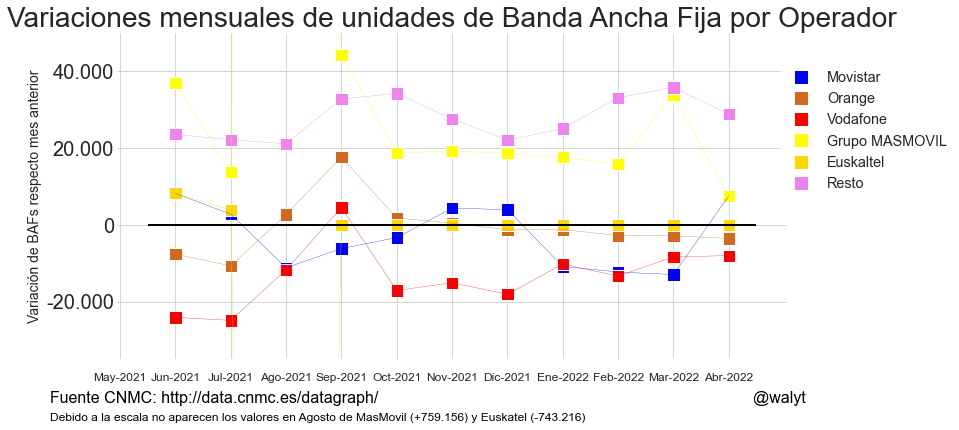

In [61]:
datos_draw = ftth
sns.set_style(style='white')


f, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style='white')
TITULO='Variaciones mensuales de unidades de Banda Ancha Fija por Operador'
# calculo medias antes de filtrar las horas

g =sns.scatterplot(data=datos_draw,
                   x='variable',
                   y='diferencia',
                   hue='operador',
                   hue_order=ORDEN_OPERADORES,
                   ax=ax,
                   s=150,
                   marker='s', # https://matplotlib.org/stable/api/markers_api.html
                   palette=COLORES,
                   alpha=1)

g =sns.lineplot(data=datos_draw,
                x='variable',
                y='diferencia',
                hue='operador',
                hue_order=ORDEN_OPERADORES,
                ax=ax,
                lw=.3,
                palette=COLORES
                )

ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f}'.format(v).replace(',','.')))
ax.set_ylim([-35000,50000])
ax.hlines(y=0, xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1], linewidth=2, color='black')
ax.set_title(TITULO,fontsize=28)
ax.grid(True)

ax.text(-.1, -.12, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(-.1, -.18, f'Debido a la escala no aparecen los valores en Agosto de MasMovil (+759.156) y Euskatel (-743.216)',horizontalalignment='left',
          verticalalignment='center', fontsize=12,color='black',transform=ax.transAxes)
ax.text(.95, -.12, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Variación de BAFs respecto mes anterior',fontsize=14)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
line1 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[0])
line2 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor=COLORES[1])
line3 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[2])
line4 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor=COLORES[3])
line5 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[4])
line6 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor=COLORES[5])

leyenda = ax.legend((line1,line2,line3,line4,line5,line6),
                      ORDEN_OPERADORES,
                      numpoints=1,
                      loc='center left',
                      bbox_to_anchor=(.98,.7),
                      ncol=1,
                      fontsize='x-large')
leyenda.get_frame().set_linewidth(0.0)
for handle in leyenda.legendHandles:
    handle.set_markersize(14)

f.savefig(f'{PATH}{PATH_IMAGEN}historico_var_bafs{MES_ACTUAL}.png',bbox_inches='tight') 

# Informes fuentes BAFs

In [62]:
baf = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_BANDA_ANCHA_FIJA_MINORISTA}{PATH_DATOS_3_4_OPERADOR}{FILE_16}',skiprows=4,nrows=9)

In [63]:
baf

,Unnamed: 0,Unnamed: 1,Ene-2015,Feb-2015,Mar-2015,Abr-2015,May-2015,Jun-2015,Jul-2015,Ago-2015,...,Jul-2021,Ago-2021,Sep-2021,Oct-2021,Nov-2021,Dic-2021,Ene-2022,Feb-2022,Mar-2022,Abr-2022
0,DSL,NaN,8893191,8787508,8667365,8554576,8450722,8352431,8250275,8158403,...,1459392,1423039,1380659,1339490,1301944,1265672,1230861,1192518,1150062,1113760
1,NaN,Movistar,4367314,4299360,4228715,4155573,4064655,3997667,3928867,3869303,...,815160,795957,773738,750530,730432,712307,693248,672851,648983,627477
2,NaN,Resto,4525877,4488148,4438650,4399003,4386067,4354764,4321408,4289100,...,644232,627082,606921,588960,571512,553365,537613,519667,501079,486283
3,HFC,NaN,2175535,2199355,2228964,2259205,2290499,2305820,2304674,2307476,...,2027225,2002803,1990024,1963186,1937800,1915354,1897493,1870736,1860437,1846268
4,FTTH,NaN,1679116,1806851,1933336,2007156,2095666,2201896,2317653,2425247,...,12203029,12282276,12435720,12542284,12643759,12727756,12803503,12891743,12984675,13064315
5,NaN,Movistar,1396294,1477579,1559286,1596243,1648227,1719402,1796355,1861083,...,4738452,4748141,4769500,4793670,4820180,4842344,4853229,4864006,4869804,4895722
6,NaN,Resto,282822,329272,374050,410913,447439,482494,521298,564164,...,7464577,7534135,7666220,7748614,7823579,7885412,7950274,8027737,8114871,8168593
7,Otras,NaN,17269,17330,17903,18373,19062,19769,20989,21527,...,259820,258152,252810,248514,246417,246322,243559,240855,245950,249057
8,Total,NaN,12765111,12811044,12847568,12839310,12855949,12879916,12893591,12912653,...,15949466,15966270,16059213,16093474,16129920,16155104,16175416,16195852,16241124,16273400


In [64]:
baf = (baf.
       assign(operador = baf['Unnamed: 1'].fillna('Total')).
       assign(tecnologia = baf['Unnamed: 0'].fillna(method='ffill')).
       drop(['Unnamed: 0'],axis=1).
       drop(['Unnamed: 1'],axis=1).
       loc[:,['tecnologia','operador']+['Mar-2021']+COLUMNAS_INTERES].
       melt(id_vars=['tecnologia','operador'],value_vars=['Mar-2021']+COLUMNAS_INTERES)
       )
baf = baf.loc[baf['operador']=='Total']

In [65]:
baf.head(11)

,tecnologia,operador,variable,value
0,DSL,Total,Mar-2021,1647738
3,HFC,Total,Mar-2021,2119006
4,FTTH,Total,Mar-2021,11836608
7,Otras,Total,Mar-2021,250406
8,Total,Total,Mar-2021,15853758
9,DSL,Total,May-2021,1541230
12,HFC,Total,May-2021,2086331
13,FTTH,Total,May-2021,12019817
16,Otras,Total,May-2021,250077
17,Total,Total,May-2021,15897455


In [66]:
baf = (baf.
        assign(diferencia = baf.groupby(['tecnologia'],sort=False)['value'].diff())
       )

In [67]:
baf = baf.loc[baf['variable']!=PENULTIMO_MES,:]

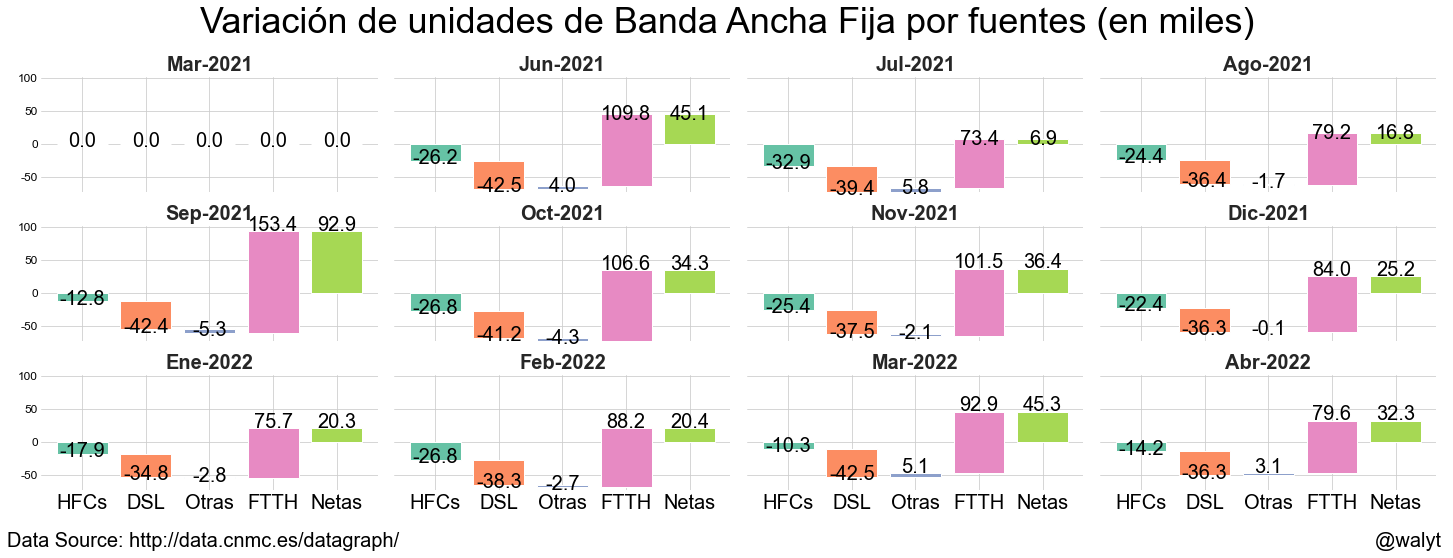

In [68]:
datos_draw = baf
sns.set_style(style='white')
TITULO='Variación de unidades de Banda Ancha Fija por fuentes (en miles)'
# calculo medias antes de filtrar las horas


g =sns.FacetGrid(data=datos_draw,
                 hue='variable',
                 col='variable',
                 sharey=True,
                 height=2.5,
                 aspect=2,
                 col_wrap=4)

#g.set_titles("",size=20)


def grafica(x,color,label):
    ax= plt.gca()
    datos = datos_draw[datos_draw['variable']==label]
    
    adsl = datos.loc[(datos['tecnologia']=='DSL'),'diferencia'].sum()
    hfc = datos.loc[(datos['tecnologia']=='HFC'),'diferencia'].sum()
    ftth = datos.loc[(datos['tecnologia']=='FTTH'),'diferencia'].sum()
    otras = datos.loc[(datos['tecnologia']=='Otras'),'diferencia'].sum()
    netas = ftth + otras + hfc + adsl
    pd_datos = pd.DataFrame({'tipo':['hfc','adsl','otras','ftth','netas'],'value':[hfc,adsl,otras,ftth,netas]})
    suelo = pd_datos.value.shift(1).fillna(0).cumsum()
    suelo.iloc[4]=0

    eje_x = ['HFCs','DSL','Otras','FTTH','Netas']
    
    paleta = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=False)
    paleta = sns.color_palette('Set2')
    ax.bar(eje_x,pd_datos.value,bottom=suelo,color=paleta)
    sns.despine(left=True, bottom=True)
    ax.xaxis.set_tick_params(labelsize=20,labelcolor='black',width=0,rotation=0,pad=0)
    ax.yaxis.set_tick_params(labelsize=12,labelcolor='black',width=0,rotation=0,pad=0)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'{y/1000:,.0f}'.replace(',','.')))
    ax.grid(True)
    patches=ax.patches
    for i,rect in enumerate(patches):
        height = rect.get_height()
        valor = f'{height/1000:,.1f}'.replace(',','.')
        pos_y = round(0.05*ax.get_ylim()[1],-4)+(height+suelo[i]) if height>0 else 4000+(height+suelo[i])
        ax.text(rect.get_x()+rect.get_width()/2,pos_y,s=valor,ha='center', va='center',fontsize=20,color='black',weight='regular')

g.map(grafica,'variable')
g.set_titles("{col_name}",size=20,weight='bold').despine(left=True,bottom=True)
#g.set_titles("")
g.set(xlabel='')
g.fig.text(0.0, -0.01, 'Data Source: {}'.format(FUENTE), horizontalalignment='left',
     verticalalignment='center', fontsize=20,color='black')
g.fig.text(.95, -.01, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=20,color='black')


g.fig.subplots_adjust(top=.85,wspace=0.05,hspace=.3)   

g.fig.suptitle('{}'.format(TITULO),fontsize=36,color='black')


sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
g.savefig(f'{PATH}{PATH_IMAGEN}historico_var_fuentes_bafs_{MES_ACTUAL}.png',bbox_inches='tight') 



# Evolución Tecnologías BAF

In [69]:
baf = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_BANDA_ANCHA_FIJA_MINORISTA}{PATH_LINEAS}{FILE_14}',skiprows=4,nrows=5)

In [70]:
baf = (baf.
       assign(tecnologia = baf['Unnamed: 0']).
       drop(['Unnamed: 0'],axis=1).
       melt(id_vars=['tecnologia'],value_vars=baf.columns[1:])
       )

In [71]:
baf

,tecnologia,variable,value
0,DSL,Ene-2015,8893191
1,HFC,Ene-2015,2175535
2,FTTH,Ene-2015,1679116
3,Otras,Ene-2015,17269
4,Total,Ene-2015,12765111
...,...,...,...
435,DSL,Abr-2022,1113760
436,HFC,Abr-2022,1846268
437,FTTH,Abr-2022,13064315
438,Otras,Abr-2022,249057


In [72]:
etiquetas_x = baf.variable.unique()

In [73]:
h.

SyntaxError: invalid syntax (2504719628.py, line 1)

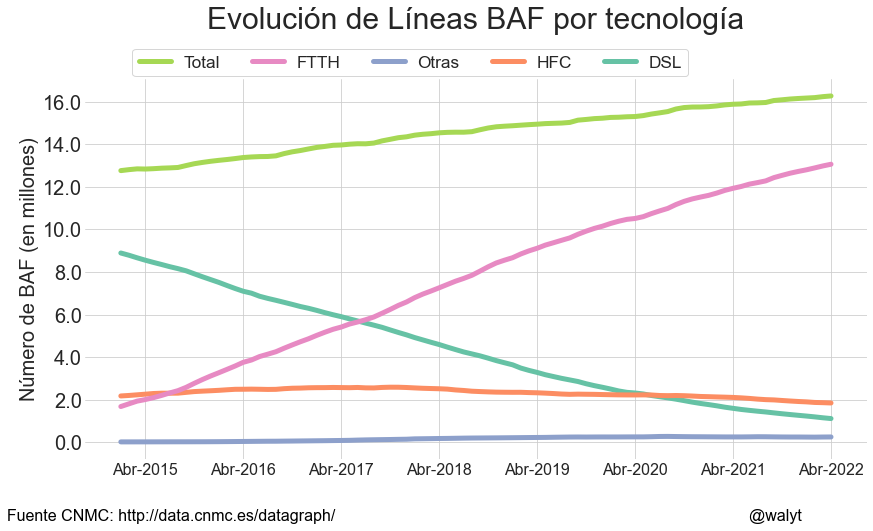

In [76]:
sns.set_style(style='white')

COLORES = sns.color_palette('Set2',5)

f, ax = plt.subplots(figsize=(14, 7))
TITULO='Evolución de Líneas BAF por tecnología'
# calculo medias antes de filtrar las horas

sns.lineplot(x="variable", y="value",hue='tecnologia',data=baf,lw=5,palette=COLORES,hue_order=['DSL','HFC','Otras','FTTH','Total'])




ax.xaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)

#ojo!....cambiarlo!
ax.set_xticks(ax.get_xticks()[3::12])

ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.1f}'.format(v/1000000).replace(',','.')))


ax.set_title(TITULO,fontsize=30,pad=50)
ax.grid(True)


handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], fontsize=16,loc='upper left',bbox_to_anchor=(.05,1.1),ncol=5)

for line in leg.get_lines():
    line.set_linewidth(5)
    
for text in leg.get_texts():
    text.set_fontsize('xx-large')
    
ax.text(-.1, -.15, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.text(.85, -.15, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Número de BAF (en millones)',fontsize=20)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
            

f.savefig(f'{PATH}{PATH_IMAGEN}evolucion_BAF_{MES_ACTUAL}.png',bbox_inches='tight') 

plt.show()

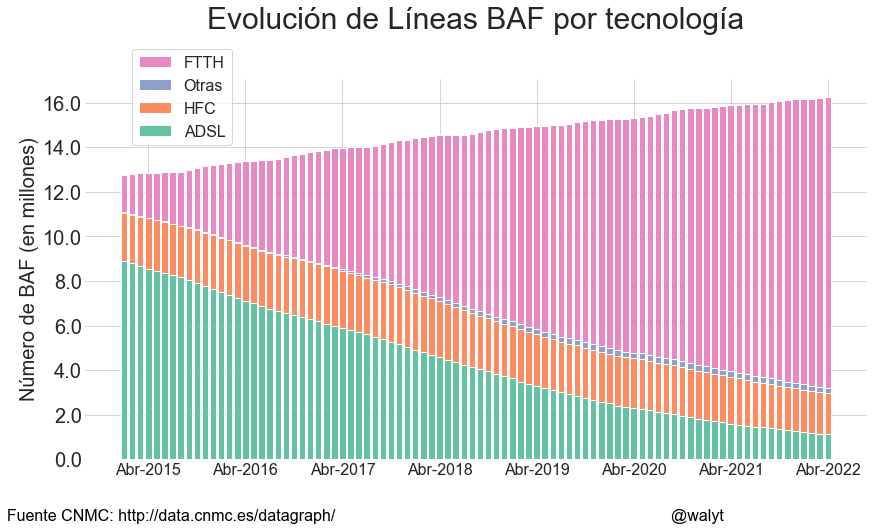

In [77]:
sns.set_style(style='white')

COLORES = sns.color_palette('Set2',10)

f, ax = plt.subplots(figsize=(14, 7))
TITULO='Evolución de Líneas BAF por tecnología'
# calculo medias antes de filtrar las horas

ax.bar(etiquetas_x,baf.loc[baf['tecnologia']=='DSL','value'],label='ADSL',color=COLORES[0])
ax.bar(etiquetas_x,baf.loc[baf['tecnologia']=='HFC','value'],bottom=baf.loc[baf['tecnologia']=='DSL','value'],label='HFC',color=COLORES[1])
ax.bar(etiquetas_x,baf.loc[baf['tecnologia']=='Otras','value'],bottom=baf.loc[baf['tecnologia'].isin(['HFC','DSL']),:].groupby('variable',sort=False).sum().value,label='Otras',color=COLORES[2])
ax.bar(etiquetas_x,baf.loc[baf['tecnologia']=='FTTH','value'],bottom=baf.loc[baf['tecnologia'].isin(['HFC','DSL','Otras']),:].groupby('variable',sort=False).sum().value,label='FTTH',color=COLORES[3])

ax.xaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)

#ojo!!!....cambiarlo
ax.set_xticks(ax.get_xticks()[3::12])

ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.1f}'.format(v/1000000).replace(',','.')))


ax.set_title(TITULO,fontsize=30,pad=50)
ax.grid(True)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16,loc='upper left',bbox_to_anchor=(.05,1.1))


ax.text(-.1, -.15, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.text(.75, -.15, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Número de BAF (en millones)',fontsize=20)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
            

f.savefig(f'{PATH}{PATH_IMAGEN}evolucion_BAF_stacked_{MES_ACTUAL}.png',bbox_inches='tight') 

plt.show()

# Prepago vs PostPago

In [78]:
moviles = pd.read_excel(f'{PATH}{PATH_DATOS}{PATH_MES}{PATH_LINEAS_MOVILES}{PATH_LINEAS}{FILE_4}',skiprows=4,nrows=3)

In [79]:
moviles = (moviles.
           assign(tipo = moviles['Unnamed: 0']).
           loc[:,['tipo']+list(COLUMNAS_INTERES)].
           melt(id_vars=['tipo'],value_vars=COLUMNAS_INTERES))
moviles['pct'] = moviles.groupby('variable').transform(lambda x:2*x/x.sum())
moviles['inc'] = moviles.loc[:,['tipo','variable','value']].groupby(['tipo'])['value'].pct_change()

/var/folders/_p/bc_h4mbs0350g3s_n60vsd3c0000gp/T/ipykernel_22940/803943679.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  moviles['pct'] = moviles.groupby('variable').transform(lambda x:2*x/x.sum())


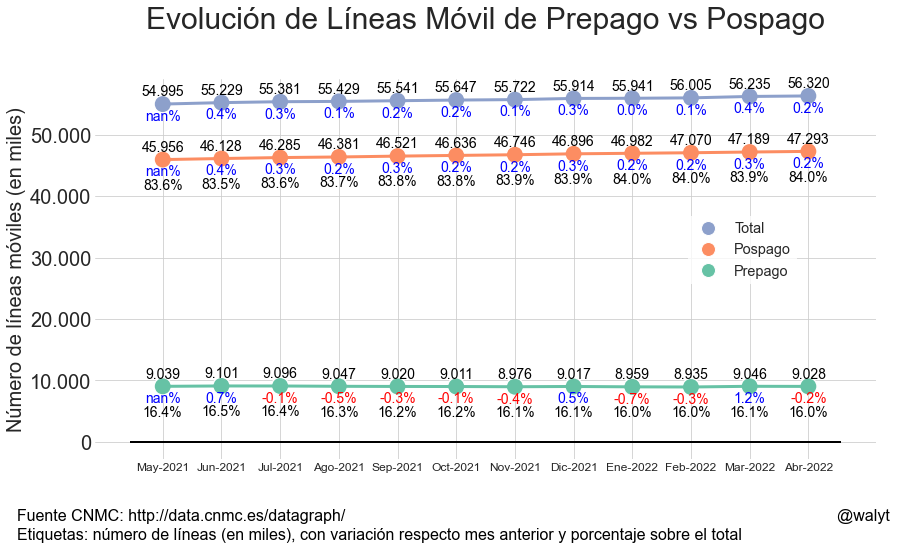

In [80]:
datos_draw = moviles
sns.set_style(style='white')

COLORES = sns.color_palette('Set2',10)
COLORES  = COLORES[:3]  #https://matplotlib.org/stable/gallery/color/named_colors.html
ORDEN_TIPO = ['Prepago','Pospago','Total']
f, ax = plt.subplots(figsize=(14, 7))
TITULO='Evolución de Líneas Móvil de Prepago vs Pospago'
# calculo medias antes de filtrar las horas

g =sns.scatterplot(data=datos_draw,
                   x='variable',
                   y='value',
                   hue='tipo',
                   hue_order=ORDEN_TIPO,
                   ax=ax,
                   s=300,
                   marker='o', # https://matplotlib.org/stable/api/markers_api.html
                   palette=COLORES,
                   alpha=1)

g =sns.lineplot(data=datos_draw,
                x='variable',
                y='value',
                hue='tipo',
                hue_order=ORDEN_TIPO,
                ax=ax,
                lw=3,
                palette=COLORES
                )

ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)
ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f}'.format(v/1000).replace(',','.')))
#ax.set_ylim([-50000,50000])
ax.hlines(y=0, xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1], linewidth=2, color='black')
ax.set_title(TITULO,fontsize=30,pad=50)
ax.grid(True)

ax.text(-.1, -.15, f'Fuente CNMC: {FUENTE} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(-.1, -.2, f'Etiquetas: número de líneas (en miles), con variación respecto mes anterior y porcentaje sobre el total',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)
ax.text(.95, -.15, f'{AUTOR} ',horizontalalignment='left',
          verticalalignment='center', fontsize=16,color='black',transform=ax.transAxes)

ax.set_xlabel('')
ax.set_ylabel('Número de líneas móviles (en miles)',fontsize=20)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=COLORES[0])
line2 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor=COLORES[1])
line3 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=COLORES[2])

leyenda = ax.legend((line3,line2,line1),
                      ORDEN_TIPO[::-1],
                      numpoints=1,
                      loc='center left',
                      bbox_to_anchor=(.75,.55),
                      ncol=1,
                      fontsize='x-large')
leyenda.get_frame().set_linewidth(0.0)
for handle in leyenda.legendHandles:
    handle.set_markersize(14)
    
patches=ax.patches
for i in datos_draw.index:
    height = 1
    valor_abs = f'{datos_draw.loc[i,:].value/1000000:,.3f}'.replace(',','.')
    valor_pct = f'{datos_draw.loc[i,:].pct:,.1%}'.replace(',','.')
    valor_inc = f'{datos_draw.loc[i,:].inc:,.1%}'.replace(',','.')
    valor_abs = f'{datos_draw.loc[i,:].value/1000000:,.3f}'.replace(',','.')
    color_inc = 'red' if datos_draw.loc[i,:].inc<0 else 'blue'

    if datos_draw.loc[i,:].tipo!='Total':
        
        ax.text(datos_draw.loc[i,:].variable,datos_draw.loc[i,:].value+2000000,s=valor_abs,ha='center', va='center',fontsize=14,color='black',weight='regular')
        ax.text(datos_draw.loc[i,:].variable,datos_draw.loc[i,:].value-4200000,s=valor_pct,ha='center', va='center',fontsize=14,color='black',weight='regular')
        ax.text(datos_draw.loc[i,:].variable,datos_draw.loc[i,:].value-2000000,s=valor_inc,ha='center', va='center',fontsize=14,color=color_inc,weight='regular')
    else:
        
        ax.text(datos_draw.loc[i,:].variable,datos_draw.loc[i,:].value+2000000,s=valor_abs,ha='center', va='center',fontsize=14,color='black',weight='regular')
        ax.text(datos_draw.loc[i,:].variable,datos_draw.loc[i,:].value-2000000,s=valor_inc,ha='center', va='center',fontsize=14,color=color_inc,weight='regular')
    
f.savefig(f'{PATH}{PATH_IMAGEN}pre_post_{MES_ACTUAL}.png',bbox_inches='tight') 